In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
clients = pd.read_csv('customers.csv')
clients

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord
...,...,...,...,...,...
788,CJ-11875,Carl Jackson,Corporate,Pennsylvania,Philadelphia
789,RS-19870,Roy Skaria,Home Office,Iowa,Burlington
790,SC-20845,Sung Chung,Consumer,Illinois,Arlington Heights
791,RE-19405,Ricardo Emerson,Consumer,Ohio,Kent


In [3]:
orders = pd.read_csv('orders.csv')
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [4]:
orders = orders[orders['order_date'] >= '2016-01-01']

In [5]:
cohorts = orders.groupby('customer_id', as_index=True).min()['order_date']
cohorts = pd.DataFrame(cohorts)
cohorts.reset_index(level=0, inplace=True)
cohorts['order_date'] = pd.to_datetime(cohorts['order_date'],infer_datetime_format=True)
cohorts['Cohort'] = cohorts['order_date'].dt.strftime('%Y-%m')
cohorts = cohorts.drop(['order_date'], axis = 1)

In [6]:
cohorts

,customer_id,Cohort
0,AA-10315,2016-03
1,AA-10375,2016-07
2,AA-10480,2016-07
3,AA-10645,2016-07
4,AB-10015,2016-11
...,...,...
768,XP-21865,2016-08
769,YC-21895,2016-04
770,YS-21880,2017-04
771,ZC-21910,2016-03


In [7]:
df_merged = pd.merge(orders,cohorts , how='left', on='customer_id')

In [8]:
df_merged['order_date'] = pd.to_datetime(df_merged['order_date'],infer_datetime_format=True)
df_merged['order_month'] = df_merged['order_date'].dt.strftime('%Y-%m') 

In [9]:
df_merged

,id,order_date,ship_mode,customer_id,sales,Cohort,order_month
0,100041,2016-11-20,Standard,BF-10975,328.540,2016-11,2016-11
1,100083,2016-11-24,Standard,CD-11980,24.784,2016-11,2016-11
2,100153,2016-12-13,Standard,KH-16630,63.880,2016-07,2016-12
3,100244,2016-09-20,Standard,GM-14695,475.694,2016-09,2016-09
4,100300,2016-06-24,Second,MJ-17740,4823.090,2016-04,2016-06
...,...,...,...,...,...,...,...
2997,168802,2017-11-03,Standard,JO-15145,18.368,2016-01,2017-11
2998,169320,2017-07-23,Second,LH-16900,171.430,2016-06,2017-07
2999,169488,2017-09-07,First,AA-10375,56.860,2016-07,2017-09
3000,169502,2017-08-28,Standard,MG-17650,113.410,2016-11,2017-08


In [10]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [11]:
cohorts_group = df_merged.groupby(['Cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)


In [12]:
user_retention.T

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Cohort,,,,,,,,,,,,,,,,,,,,,
2016-01,1.0,0.021739,0.043478,0.086957,0.108696,0.108696,0.130435,0.086957,0.173913,0.130435,...,0.173913,0.130435,0.195652,0.152174,0.130435,0.130435,0.173913,0.130435,0.239130,0.23913
2016-02,1.0,0.073171,0.073171,0.048780,0.146341,0.097561,0.048780,0.170732,0.170732,0.121951,...,0.097561,0.146341,0.146341,0.243902,0.170732,0.365854,0.170732,0.292683,0.195122,NaN
2016-03,1.0,0.106667,0.146667,0.160000,0.146667,0.080000,0.253333,0.120000,0.186667,0.240000,...,0.200000,0.200000,0.066667,0.120000,0.293333,0.200000,0.253333,0.266667,NaN,NaN
2016-04,1.0,0.147059,0.102941,0.147059,0.132353,0.308824,0.117647,0.161765,0.235294,0.102941,...,0.161765,0.088235,0.088235,0.294118,0.073529,0.235294,0.323529,NaN,NaN,NaN
2016-05,1.0,0.088235,0.147059,0.073529,0.279412,0.147059,0.279412,0.161765,0.088235,0.044118,...,0.088235,0.147059,0.235294,0.161765,0.308824,0.220588,NaN,NaN,NaN,NaN
2016-06,1.0,0.074074,0.074074,0.277778,0.129630,0.240741,0.240741,0.037037,0.018519,0.185185,...,0.111111,0.203704,0.203704,0.277778,0.222222,NaN,NaN,NaN,NaN,NaN
2016-07,1.0,0.136364,0.295455,0.068182,0.181818,0.204545,0.045455,0.090909,0.068182,0.159091,...,0.181818,0.159091,0.295455,0.272727,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.180000,0.080000,0.160000,0.100000,0.040000,0.120000,0.080000,0.200000,0.160000,...,0.180000,0.320000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1.0,0.046154,0.230769,0.138462,0.107692,0.076923,0.169231,0.153846,0.153846,0.107692,...,0.246154,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


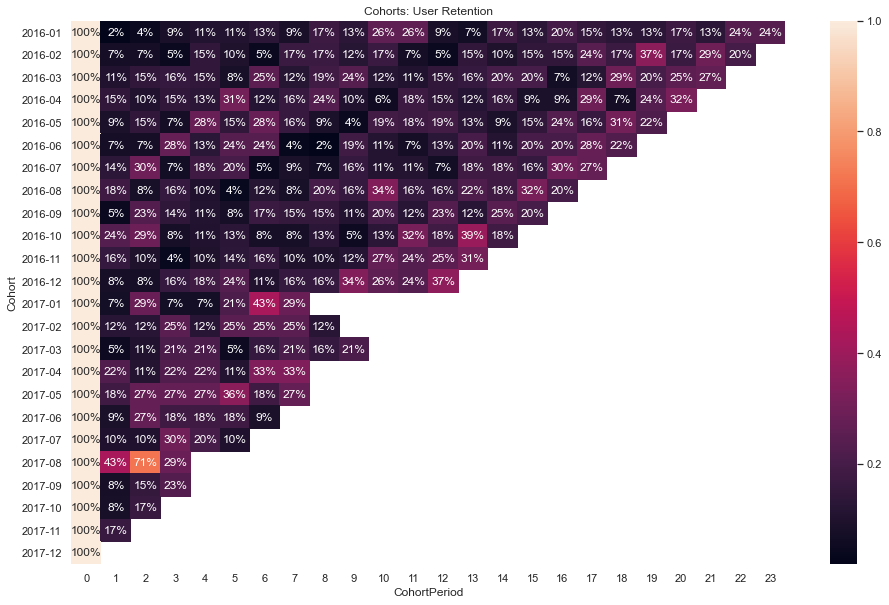

In [13]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Остаётся сравнить два года: 17 и 16. 
- Во-первых, видно, что в первых 12 строках диагональ первого квадрата 12на12 (с левым нижним концом в 2016-12) гораздо темнее чем диагональ второго квадрата 12 на 12 (которая есть часть диагонали всей heatmap), в первом случае в среднем 8% на диагонали, во втором больше 20%. Это значит, что retention когорт 16го года (который руководитель проекта называет "прошлым") стал гораздо лучше в 17ом году (по сравнению с тем, что было до), то есть после действий, совершенных в бизнесе в 17ом году
- Во-вторых, видно, что нижняя часть heatmap (тоже  половина квадратика 12 на 12), отвечающая только за когорты 2017 года, окрашена ярче, чем аналогичная часть heatmap, отвечающая только за когорты 2016 года. Это опять же значит, что бизнес решения, проведенные в 17ом году, сделали лучше, чем было в аналогичный период в 16ом году
- Правда, в части heatmap, отвечающей за 2017 год, есть белые пропуски -- это вообще-то плохо, часть данных не видно (а вдруг именно на этих квадратиках когорты решили уйти?непонятно), это наверное можно списать на то что данные свкежие и еще не до конца собраны (типа 2017 год -- нынешний), в общем держать в голове это нужно
- Так или иначе, из анализа heatmap становится понятно, что в 2017 году всё стало лучше, чем было в предыдущем, 16-ом